# Mass Shooting Analysis_ NLP Exploration

In [1]:
import json
import pandas as pd
from pathlib import Path
import seaborn as sns
import regex as re
import wikipedia as wp
import numpy as np
from itertools import combinations
import warnings
import random
from upsetplot import UpSet, from_indicators

import spacy
from spacy import displacy
import textacy

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

In [2]:
html = wp.page("List_of_mass_shootings_in_the_United_States_in_2024", auto_suggest=False).html().encode("UTF-8")
try: 
    w24_df = pd.read_html(html)[1]  # Try 2nd table first as most pages contain contents table first
except IndexError:
    w24_df = pd.read_html(html)[0]
w24_df.head(5)

,2024 date,Location,State or territory,Dead,Injured,Total,Description
0,December 31,Adams County,Mississippi,1,5,6,A man was killed and five others were injured ...
1,December 31,Oakland (4),California,1,3,4,A group of people were fired at in the Jack Lo...
2,December 30,Rochester (3),New York,0,4,4,Three teenagers and a young adult were shot in...
3,December 30,New York City (10),New York,0,6,6,Six people were shot in the Williamsbridge nei...
4,December 28,Signal Hill,California,1,6,7,"Seven teenagers, including a girl who died, we..."


In [3]:
w24_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   2024 date           589 non-null    object
 1   Location            589 non-null    object
 2   State or territory  589 non-null    object
 3   Dead                589 non-null    object
 4   Injured             589 non-null    object
 5   Total               589 non-null    int64 
 6   Description         589 non-null    object
dtypes: int64(1), object(6)
memory usage: 32.3+ KB


In [4]:
w24_df['date'] = w24_df['2024 date'] + ', 2024'

In [5]:
w24_df['date'] = pd.to_datetime(w24_df['date'], format = '%B %d, %Y', errors = 'coerce')

In [6]:
invalid_mask = w24_df["date"].isna()
invalid_entries = w24_df.loc[invalid_mask, "date"]
print(invalid_entries)

534   NaT
Name: date, dtype: datetime64[ns]


In [7]:
w24_df.at[534, 'date'] = pd.to_datetime('02/12/2024')
w24_df[533:535]

,2024 date,Location,State or territory,Dead,Injured,Total,Description,date
533,February 12,New York City (2),New York,1,5,6,One person was killed and five others injured ...,2024-02-12
534,February 11â12,"Huntington Park, Florence-Graham, & Cudahy",California,4,1,5,Three males went on an apparent random shootin...,2024-02-12


In [8]:
def clean_text(text):
    # tags like (Mo.,Di. etc)
    text = re.sub(r'\(.*\)', ' ', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    # lowercase text (Not for German, NER)
    text = text.lower()
    return text.strip()

def clean_loc(text):
    # tags like (Mo.,Di. etc)
    text = re.sub(r'\(.*\)', ' ', text)
    return text

def clean_notes(text):
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    return text

In [9]:
# Cleaning all (notes) anf other [things] from data and text columns
w24_df['text'] = w24_df['Description'].map(clean_text)
w24_df['Location'] = w24_df['Location'].map(clean_loc)
w24_df['Dead'] = w24_df['Dead'].map(clean_notes)
w24_df['Injured'] = w24_df['Injured'].map(clean_notes)

In [10]:
# Correcting datatypes
w24_df['Dead'], w24_df['Injured'], w24_df['Total'] = w24_df['Dead'].astype(int), w24_df['Injured'].astype(int), w24_df['Total'].astype(int)
w24_df['Location'], w24_df['State'] = w24_df['Location'].astype(str), w24_df['State or territory'].astype(str)
w24_df['dow'] = w24_df['date'].dt.day_name().str[:3]
w24_df['month'] = w24_df['date'].dt.month_name().str[:3]
w24_df['week'] = w24_df['date'].dt.isocalendar().week
w24_df.head(5)


,2024 date,Location,State or territory,Dead,Injured,Total,Description,date,text,State,dow,month,week
0,December 31,Adams County,Mississippi,1,5,6,A man was killed and five others were injured ...,2024-12-31,a man was killed and five others were injured ...,Mississippi,Tue,Dec,1
1,December 31,Oakland,California,1,3,4,A group of people were fired at in the Jack Lo...,2024-12-31,a group of people were fired at in the jack lo...,California,Tue,Dec,1
2,December 30,Rochester,New York,0,4,4,Three teenagers and a young adult were shot in...,2024-12-30,three teenagers and a young adult were shot in...,New York,Mon,Dec,1
3,December 30,New York City,New York,0,6,6,Six people were shot in the Williamsbridge nei...,2024-12-30,six people were shot in the williamsbridge nei...,New York,Mon,Dec,1
4,December 28,Signal Hill,California,1,6,7,"Seven teenagers, including a girl who died, we...",2024-12-28,"seven teenagers, including a girl who died, we...",California,Sat,Dec,52


In [11]:
df = w24_df.drop(columns=['2024 date', 'State or territory', 'Description'])

In [12]:
df = df.rename(columns={
    'Location': 'city',
    'State': 'state',
    'Dead': 'dead',
    'Injured': 'injured',
    'Total': 'total'
    })


In [13]:
df = df[['date', 'dow', 'month','week', 'city', 'state', 'dead', 'injured', 'total', 'text']]
df.style.format({"date": lambda t: t.strftime("%d-%m-%Y")}) 
df.head(5)

,date,dow,month,week,city,state,dead,injured,total,text
0,2024-12-31,Tue,Dec,1,Adams County,Mississippi,1,5,6,a man was killed and five others were injured ...
1,2024-12-31,Tue,Dec,1,Oakland,California,1,3,4,a group of people were fired at in the jack lo...
2,2024-12-30,Mon,Dec,1,Rochester,New York,0,4,4,three teenagers and a young adult were shot in...
3,2024-12-30,Mon,Dec,1,New York City,New York,0,6,6,six people were shot in the williamsbridge nei...
4,2024-12-28,Sat,Dec,52,Signal Hill,California,1,6,7,"seven teenagers, including a girl who died, we..."


In [14]:
df.to_csv('ms_2024_wiki_nlp_df.csv')

In [15]:
#Re-run to get cleaned base data for NLP changes
df = pd.read_csv('ms_2024_wiki_nlp_df.csv', index_col=0,
                 dtype = {'date': str, 'dow': str, 'month': str, 'week':int,'city': str, 'state': str, \
                          'dead': int, 'injured': int, 'total': int, 'text': str})
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d', errors = 'coerce') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589 entries, 0 to 588
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     589 non-null    datetime64[ns]
 1   dow      589 non-null    object        
 2   month    589 non-null    object        
 3   week     589 non-null    int32         
 4   city     589 non-null    object        
 5   state    589 non-null    object        
 6   dead     589 non-null    int32         
 7   injured  589 non-null    int32         
 8   total    589 non-null    int32         
 9   text     589 non-null    object        
dtypes: datetime64[ns](1), int32(4), object(5)
memory usage: 41.4+ KB


In [16]:
nlp = spacy.load('en_core_web_lg')

In [17]:
def extract_spacy_features(df, text_column='text'):
    """Extract spaCy features and add to dataframe"""
    df = df.copy()
        
    def process_text(text):
        if pd.isna(text) or text == '':
            return {
                'tokens': [],
                'lemmas': [],
                'pos_tags': [],
                'all_ents': [],
                'loc_ents': [],
                'time_ents': [],
                'fac_ents': [],
                'noun_chunks': [],
                'verbs': [],
                'nouns': [],
            }
            
        doc = nlp(text)
            
        return {
            'tokens': [token.text for token in doc if not token.is_stop and not token.is_punct],
            'lemmas': [token.lemma_ for token in doc if not token.is_stop and not token.is_punct],
            'pos_tags': [token.pos_ for token in doc],
            'all_ents': [(ent.text, ent.label_) for ent in doc.ents],
            'loc_ents': [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'LOC' and not ent.text in not_loc],
            'time_ents': [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'TIME' and not ent.text in not_org],
            'fac_ents': [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'FAC' and not ent.text in not_per],
            'noun_chunks': [chunk.text for chunk in doc.noun_chunks if len(chunk) > 1],
            'verbs' : [token.text for token in doc if token.pos_ == 'VERB' if not token.is_stop],
            'nouns' : [token.text for token in doc if token.pos_ == 'NOUN' if not token.is_stop]
        }
    # Non-entities - Ents listed as Ents that shouldn't be in there
    not_loc = [] 
    not_org = []
    not_per = [] 
    
    # Process all texts
    print("Processing texts with spaCy...")
    spacy_features = df[text_column].apply(process_text)
        
    # Add features as new columns
    df['tokens'] = spacy_features.apply(lambda x: x['tokens'])
    df['lemmas'] = spacy_features.apply(lambda x: x['lemmas'])
    df['pos_tags'] = spacy_features.apply(lambda x: x['pos_tags'])
    df['all_ents'] = spacy_features.apply(lambda x: x['all_ents'])
    df['loc_ents'] = spacy_features.apply(lambda x: x['loc_ents'])
    df['time_ents'] = spacy_features.apply(lambda x: x['time_ents'])
    df['fac_ents'] = spacy_features.apply(lambda x: x['fac_ents'])
    df['noun_chunks'] = spacy_features.apply(lambda x: x['noun_chunks'])
    df['verbs'] = spacy_features.apply(lambda x: x['verbs'])
    df['nouns'] = spacy_features.apply(lambda x: x['nouns'])

        
    # Create processed text from lemmas for further analysis
    df['lemmatized_text'] = df['lemmas'].apply(lambda x: ' '.join(x))
        
    return df

In [18]:
df = extract_spacy_features(df)
df.head(2)

Processing texts with spaCy...


,date,dow,month,week,city,state,dead,injured,total,text,...,lemmas,pos_tags,all_ents,loc_ents,time_ents,fac_ents,noun_chunks,verbs,nouns,lemmatized_text
0,2024-12-31,Tue,Dec,1,Adams County,Mississippi,1,5,6,a man was killed and five others were injured ...,...,"[man, kill, injure, shooting, attack, south, n...","[DET, NOUN, AUX, VERB, CCONJ, NUM, NOUN, AUX, ...","[(five, CARDINAL), (natchez, ORG)]",[],[],[],"[a man, five others, a shooting attack]","[killed, injured]","[man, shooting, attack]",man kill injure shooting attack south natchez
1,2024-12-31,Tue,Dec,1,Oakland,California,1,3,4,a group of people were fired at in the jack lo...,...,"[group, people, fire, jack, london, square, ar...","[DET, NOUN, ADP, NOUN, AUX, VERB, ADP, ADP, DE...","[(three, CARDINAL)]",[],[],[],"[a group, the jack london square area, a man, ...","[fired, killing, wounding]","[group, people, man]",group people fire jack london square area kill...


In [19]:
from collections import Counter 
def count_words(df, column='tokens', preprocess=None, min_freq=1):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [20]:
count_words(df, column = 'verbs').head(5)

,freq
token,
injured,305
killed,254
shot,204
including,100
opened,87


In [21]:
#SOURCE page 191 in Learning Data Science

def make_situ_categories(df):
    def has(term):
        return df['text'].str.contains(term)
    
    return df[:].assign(
        homey = has(r"house|home|apartment|residence|property"),
        bar_club = has(r"club|bar|party|gathering|lounge|establishment|pub|restaurant"),
        school = has(r"school|college|university|campus"),
        retail = has(r"store|shop|mall|gas station"),
        outdoors = has(r"park|city|downtown|residential area|playground|field"),
        vehicle = has(r"car|truck|suv|vehicle|van|pick-up|drive-by|bus"),
        gang = has(r"gang"),
        fight = has(r"fight|argument|disagree|dispute"),
        domestic = has(r"family|wife|girlfriend|boyfriend| son|daughter|brother|sister|mother|father|domestic|family member|parent"),
        suicide = has(r"own life|suicide|killing himself|killing herself"),
        youth = has(r"child|teenage|girl|boy|toddler|baby|juvenile"),
    )

df = df.pipe(make_situ_categories)


In [22]:
df.head(3)

,date,dow,month,week,city,state,dead,injured,total,text,...,bar_club,school,retail,outdoors,vehicle,gang,fight,domestic,suicide,youth
0,2024-12-31,Tue,Dec,1,Adams County,Mississippi,1,5,6,a man was killed and five others were injured ...,...,False,False,False,False,False,False,False,False,False,False
1,2024-12-31,Tue,Dec,1,Oakland,California,1,3,4,a group of people were fired at in the jack lo...,...,False,False,False,False,False,False,False,False,False,False
2,2024-12-30,Mon,Dec,1,Rochester,New York,0,4,4,three teenagers and a young adult were shot in...,...,False,False,False,False,False,False,False,False,False,True


In [23]:
pd.options.display.date_dayfirst = True
pd.options.display.max_colwidth = None
# Set lists for x-axis order
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
calendar_mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']

In [24]:
dom_set = df[df['domestic'] == True]
dom_set['text'].head(2)

3    six people were shot in the williamsbridge neighborhood of the bronx. police allege the intended targets ran into a convenience store after they were fired at by two people in the street and that one of the targets used a woman who happened to be in the store as a human shield. the woman's 12-year-old daughter was also injured.
5                                                                                                                                                                          south of grantsville, two people were killed and two others were injured in a shooting at a house by the homeowner's son, who was later arrested in fayette county.
Name: text, dtype: object

In [25]:
for text in dom_set['text'].tail(5):
    print(text)

a woman fatally shot her husband and two daughters before committing suicide.
a man killed his estranged wife and three other family members, including his eight-year-old niece, at a home southwest of four corners before committing suicide.
a teenager fatally shot four of his neighbors at their home and robbed the house of its firearms before attempting to hide two of the victim's bodies with the help of his mother.
a man fatally shot his girlfriend and her cousin and injured his infant son before killing himself.
a man fatally shot three of his family members at a house before turning the gun on himself.


In [26]:
# Create Other Category subsets - Location of Shooting
home_set = df[df['homey'] == True]
bar_set = df[df['bar_club'] == True]
school_set = df[df['school'] == True]
ret_set = df[df['retail'] == True]
out_set = df[df['outdoors'] == True]
car_set = df[df['vehicle'] == True]
# Categories around potential causes / circumstances
fight_club = df[df['fight'] == True]
gang_set = df[df['gang'] == True]
suicide_set = df[df['suicide'] == True]
youth_set = df[df['youth'] == True]

In [27]:
school_we = df[(df['school'] == True) & ((df['dow'] == 'Sat')|(df['dow'] == 'Sun'))]
school_we['text']


45                                                                                                                                                                                                                                                                                                                                                                                      four juveniles were shot across from the denver school of the arts campus in the east side between the east colfax and park hill neighborhoods.
59                                                                                                                                                                                                                                                             tuskegee university shooting: during the 100th homecoming week celebration at tuskegee university, a man opened fire on campus, killing an unaffiliated teen and wounding at least twelve others, including students. four others

Text(0, 0.5, 'No. of Incidents (2024)')

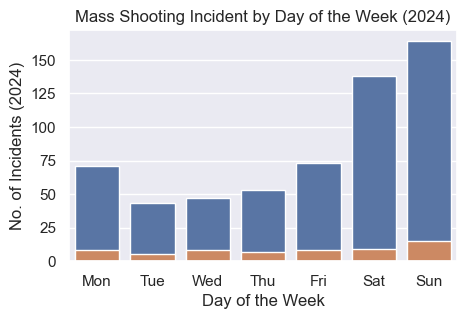

In [28]:
sns.set_theme()
plt.figure(figsize=(5,3))
sns.countplot(df, x='dow', 
              order = days_of_week
             ).set_title('Mass Shooting Incident by Day of the Week (2024)')
sns.countplot(dom_set, x='dow', order=days_of_week)
plt.xlabel('Day of the Week')
plt.ylabel('No. of Incidents (2024)')

Text(0.5, 0, 'Days of the Week')

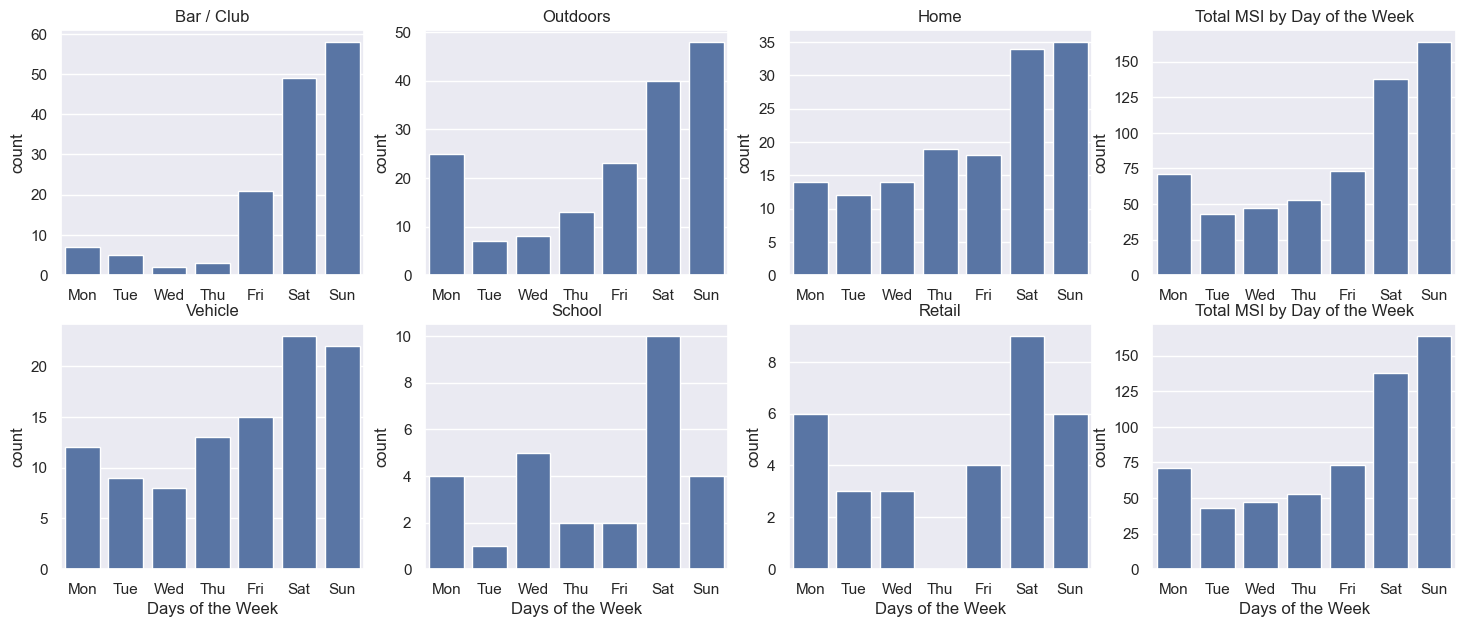

In [48]:
## Set up label variables
title = 'Total MSI by Day of the Week'
d_of_w = 'Days of the Week'

# Set up the matplotlib figure
f, axes = plt.subplots(2, 4, figsize=(18, 7), sharey=False)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

sns.countplot(bar_set, x='dow', ax=ax1, order=days_of_week).set_title('Bar / Club')
ax1.set_xlabel(None)

sns.countplot(out_set, x='dow', ax=ax2, order=days_of_week).set_title('Outdoors')
ax2.set_xlabel(None)

sns.countplot(home_set, x='dow', ax=ax3, order=days_of_week).set_title('Home')
ax3.set_xlabel(None)

sns.countplot(df, x='dow', ax=ax4, order=days_of_week).set_title(title)
ax4.set_xlabel(None)

sns.countplot(car_set, x='dow', ax=ax5, order=days_of_week).set_title('Vehicle')
ax5.set_xlabel(d_of_w)

sns.countplot(school_set, x='dow', ax=ax6, order=days_of_week).set_title('School')
ax6.set_xlabel(d_of_w)

sns.countplot(ret_set, x='dow', ax=ax7, order=days_of_week).set_title('Retail')
ax7.set_xlabel(d_of_w)

sns.countplot(df, x='dow', ax=ax8, order=days_of_week).set_title(title)
ax8.set_xlabel(d_of_w)

Text(0.5, 0, 'Days of the Week')

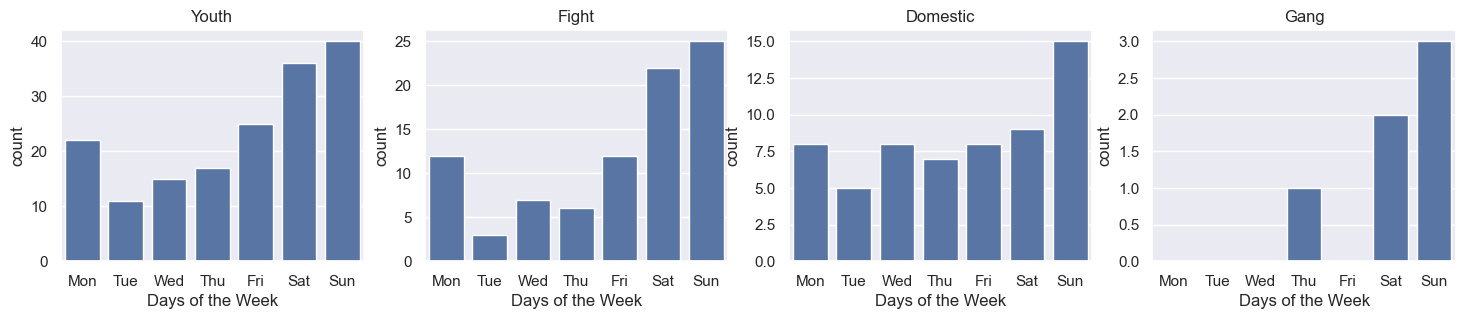

In [38]:
## Set up label variables
title = 'Total MSI by Day of the Week'
d_of_w = 'Days of the Week'

# Set up the matplotlib figure
f, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=False)
ax1, ax2, ax3, ax4 = axes.flatten()

sns.countplot(youth_set, x='dow', ax=ax1, order=days_of_week).set_title('Youth')
ax1.set_xlabel(d_of_w)

sns.countplot(fight_club, x='dow', ax=ax2, order=days_of_week).set_title('Fight')
ax2.set_xlabel(d_of_w)

sns.countplot(dom_set, x='dow', ax=ax3, order=days_of_week).set_title('Domestic')
ax3.set_xlabel(d_of_w)

sns.countplot(gang_set, x='dow', ax=ax4, order=days_of_week).set_title('Gang')
ax4.set_xlabel(d_of_w)

Text(0.5, 0, 'Days of the Week')

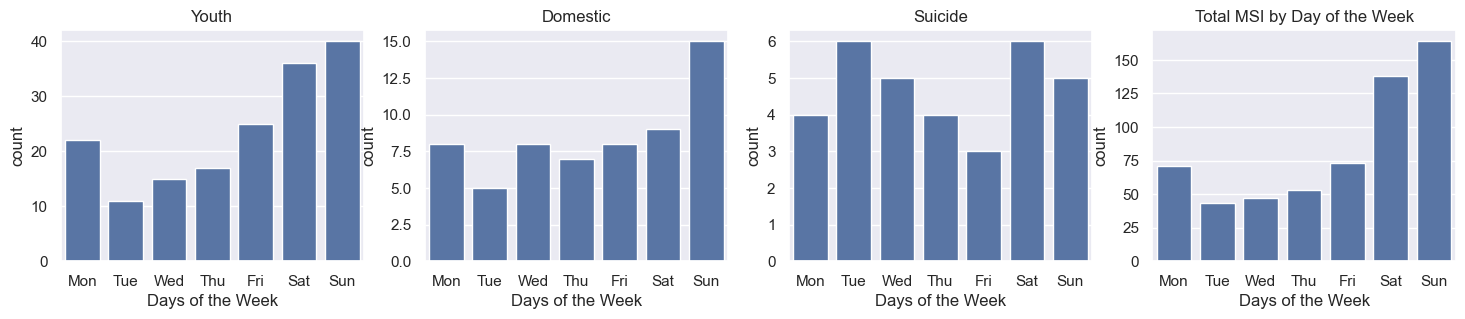

In [39]:
## Set up label variables
title = 'Total MSI by Day of the Week'
d_of_w = 'Days of the Week'

# Set up the matplotlib figure
f, axes = plt.subplots(1, 4, figsize=(18, 3), sharey=False)
ax1, ax2, ax3, ax4 = axes.flatten()

sns.countplot(youth_set, x='dow', ax=ax1, order=days_of_week).set_title('Youth')
ax1.set_xlabel(d_of_w)

sns.countplot(dom_set, x='dow', ax=ax2, order=days_of_week).set_title('Domestic')
ax2.set_xlabel(d_of_w)

sns.countplot(suicide_set, x='dow', ax=ax3, order=days_of_week).set_title('Suicide')
ax3.set_xlabel(d_of_w)

sns.countplot(df, x='dow', ax=ax4, order=days_of_week).set_title(title)
ax4.set_xlabel(d_of_w)

Text(0.5, 0, '')

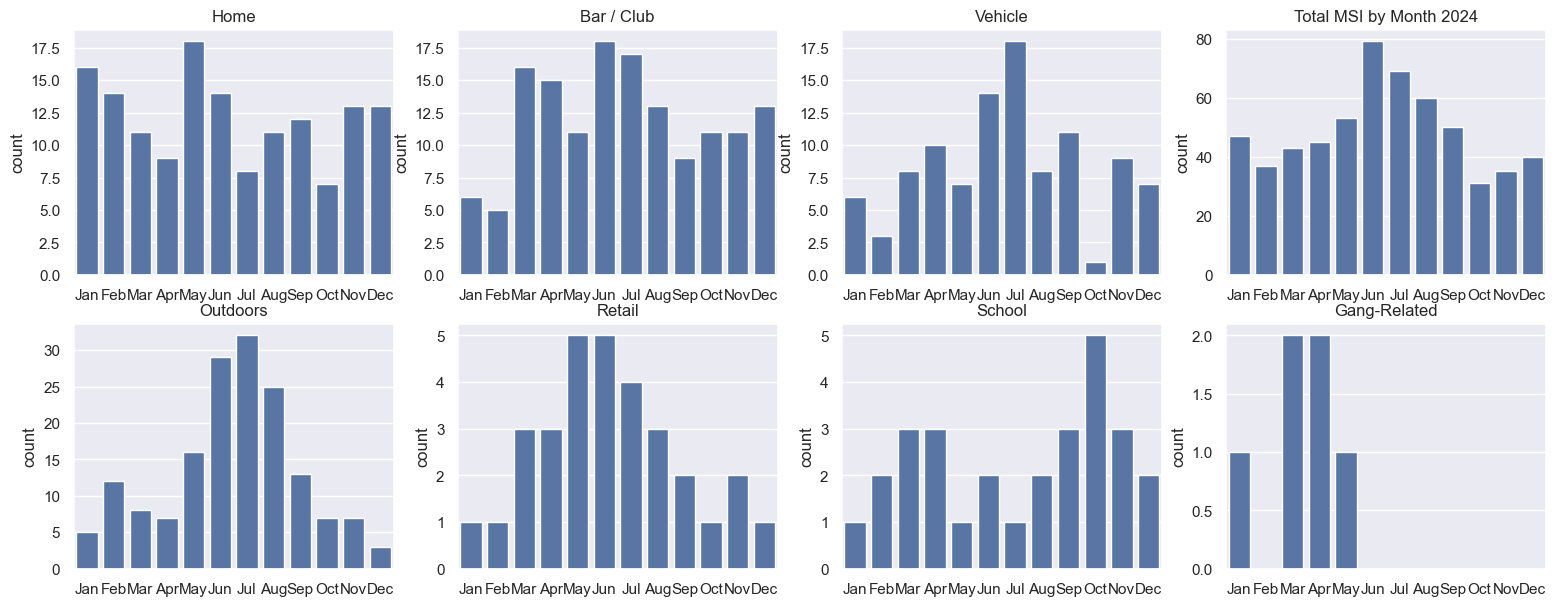

In [43]:
## Set up label variables
title = 'Total MSI by Month 2024'
d_of_w = ''
aspect = 'month'
# Set up the matplotlib figure
f, axes = plt.subplots(2, 4, figsize=(19, 7), sharey=False)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flatten()

sns.countplot(home_set, x=aspect, ax=ax1, order=calendar_mon).set_title('Home')
ax1.set_xlabel(None)

sns.countplot(bar_set, x=aspect, ax=ax2, order=calendar_mon).set_title('Bar / Club')
ax2.set_xlabel(None)

sns.countplot(car_set, x=aspect, ax=ax3, order=calendar_mon).set_title('Vehicle')
ax3.set_xlabel(None)

sns.countplot(df, x=aspect, ax=ax4, order=calendar_mon).set_title(title)
ax4.set_xlabel(None)

sns.countplot(out_set, x=aspect, ax=ax5, order=calendar_mon).set_title('Outdoors')
ax5.set_xlabel(d_of_w)

sns.countplot(ret_set, x=aspect, ax=ax6, order=calendar_mon).set_title('Retail')
ax6.set_xlabel(d_of_w)

sns.countplot(school_set, x=aspect, ax=ax7, order=calendar_mon).set_title('School')
ax7.set_xlabel(d_of_w)

sns.countplot(gang_set, x=aspect, ax=ax8, order=calendar_mon).set_title('Gang-Related')
ax8.set_xlabel(d_of_w)

Text(0.5, 0, '')

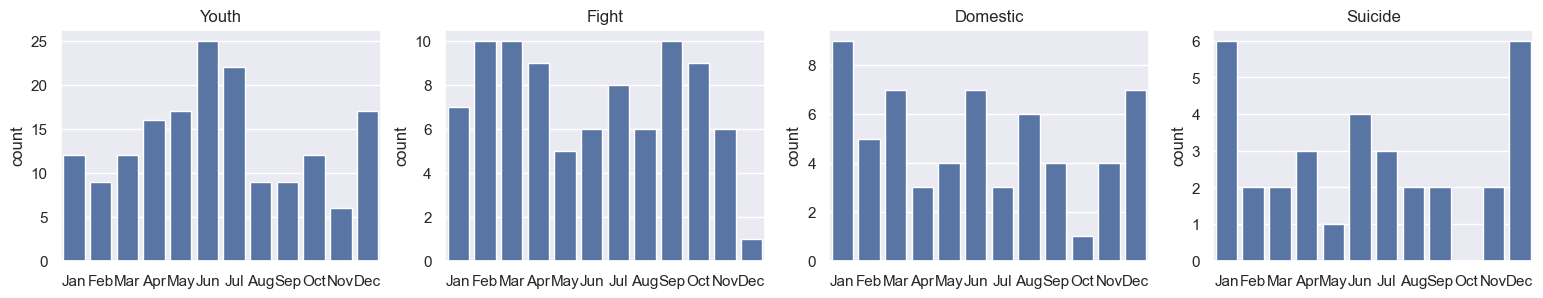

In [50]:
## Set up label variables
title = 'Total MSI by Month 2024'
d_of_w = ''
aspect = 'month'
# Set up the matplotlib figure
f, axes = plt.subplots(1, 4, figsize=(19, 3), sharey=False)
ax1, ax2, ax3, ax4 = axes.flatten()

sns.countplot(youth_set, x=aspect, ax=ax1, order=calendar_mon).set_title('Youth')
ax1.set_xlabel(None)

sns.countplot(fight_club, x=aspect, ax=ax2, order=calendar_mon).set_title('Fight')
ax2.set_xlabel(None)

sns.countplot(dom_set, x=aspect, ax=ax3, order=calendar_mon).set_title('Domestic')
ax3.set_xlabel(None)

sns.countplot(suicide_set, x=aspect, ax=ax4, order=calendar_mon).set_title('Suicide')
ax4.set_xlabel(None)

In [ ]:
## Set up label variables
title = 'Total MSI by Month 2024'
d_of_w = ''
aspect = 'month'
# Set up the matplotlib figure
f, axes = plt.subplots(1, 4, figsize=(19, 3), sharey=False)
ax1, ax2, ax3, ax4 = axes.flatten()

sns.countplot(youth_set, x=aspect, ax=ax1, order=calendar_mon).set_title('Youth')
ax1.set_xlabel(None)

sns.countplot(fight_club, x=aspect, ax=ax2, order=calendar_mon).set_title('Fight')
ax2.set_xlabel(None)

sns.countplot(dom_set, x=aspect, ax=ax3, order=calendar_mon).set_title('Domestic')
ax3.set_xlabel(None)

sns.countplot(suicide_set, x=aspect, ax=ax4, order=calendar_mon).set_title('Suicide')
ax4.set_xlabel(None)

Text(0, 0.5, 'Mass Shooting Incidents (2024)')

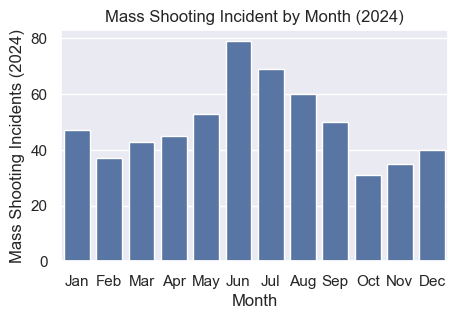

In [32]:
plt.figure(figsize=(5,3))
sns.countplot(df, x='month', 
              order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']
             ).set_title('Mass Shooting Incident by Month (2024)')

plt.xlabel('Month')
plt.ylabel('Mass Shooting Incidents (2024)')

In [29]:
if textacy.__version__ < '0.11': # as in printed book
    from textacy.text_utils import KWIC
    
else: # for textacy 0.11.x
    from textacy.extract.kwic import keyword_in_context

    def KWIC(*args, **kwargs):
        # call keyword_in_context with all params except 'print_only'
        return keyword_in_context(*args, 
                           **{kw: arg for kw, arg in kwargs.items() 
                            if kw != 'print_only'})

In [36]:
def kwic(doc_series, keyword, window=50, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

In [37]:
kwic(df['text'], 'son', print_samples=5)

5 random samples out of 62 contexts for 'son':
at least one per  son   fired into a window of an apartment, injuring fou
four people were wounded when a per  son   opened fire into a group of people in the brickto
one per  son   was killed and three were injured by two shooters
one per  son   was killed and six injured in a shooting at a gue
a man killed one per  son   and wounded two adolescents before taking his own


In [38]:
kwic(df['text'], 'school', print_samples=5)

5 random samples out of 23 contexts for 'school':
ne of the victims or suspects are students of the   school  .
eight northeast high   school   students were shot while waiting at a bus stop wh
 people were injured at benjamin elijah mays high   school   in a drive-by shooting.
school. the shooter, a 17-year-old student at the   school  , committed suicide. one of the people who was sho
four juveniles were shot across from the denver   school   of the arts campus in the east side between the e


In [39]:
df['bar_club'].value_counts(), df['school'].value_counts(), df['youth'].value_counts(), df['fight'].value_counts(), \
df['suicide'].value_counts(), df['gang'].value_counts(), df['homey'].value_counts(),df['domestic'].value_counts(),df['outdoors'].value_counts()

(bar_club
 False    444
 True     145
 Name: count, dtype: int64,
 school
 False    561
 True      28
 Name: count, dtype: int64,
 youth
 False    425
 True     164
 Name: count, dtype: int64,
 fight
 False    502
 True      87
 Name: count, dtype: int64,
 suicide
 False    556
 True      33
 Name: count, dtype: int64,
 gang
 False    583
 True       6
 Name: count, dtype: int64,
 homey
 False    443
 True     146
 Name: count, dtype: int64,
 domestic
 False    529
 True      60
 Name: count, dtype: int64,
 outdoors
 False    425
 True     164
 Name: count, dtype: int64)

In [40]:
df['bar_club':'outdoors'].value_counts()

TypeError: cannot do slice indexing on Index with these indexers [bar_club] of type str

In [159]:
doc = nlp("a man entered the home of his estranged wife armed with a rifle and shot and killed her, two other people and a dog.")

In [160]:
for token in doc:
    if token.dep_ == "dobj":
        dobj = token
        conj = [t.text for t in token.conjuncts]
        verb = dobj.head
        dobj = token.text
        print(verb, dobj, conj)

entered home []
killed her []
entered people ['dog']


In [161]:
from spacy.matcher import Matcher

In [162]:
matcher = Matcher(nlp.vocab)

In [163]:
def get_noun_phrase(token):
    """ Extract the full noun phrase for a given token """
    # Start with the token itself
    phrase_tokens = [token]
    
    # Add any children that are part of the noun phrase
    for child in token.children:
        if child.dep_ in ["det", "amod", "compound", "poss"]:
            phrase_tokens.append(child)
    
    # Sort tokens by their position in the sentence
    phrase_tokens.sort(key=lambda x: x.i)
    
    # Return the text of the noun phrase
    return " ".join([t.text for t in phrase_tokens])

In [164]:
# Define patterns for the target verbs
target_verbs = ["shoot", "kill", "injure", "wound"]

# Create patterns for each verb (including different forms)
pattern1 = []
for verb in target_verbs:
    pattern1.append([{"LEMMA": verb}])

pattern2 = []
for verb in target_verbs:
    pattern2.append([
    {"DEP": "nsubjpass"},  # Passive subject (the victim)
    {"LEMMA": "be", "DEP": "auxpass"},  # was/were/been
    {"LEMMA": verb, "TAG": "VBN"}  # past participle
    ])
# Add patterns to matcher
matcher.add("TARGET_VERBS", pattern1)
matcher.add("PASS_VERBS", pattern2)

In [165]:
def extract_subject(text):
    """ Extract subject from sentences containing target verbs - returns a list of subjects """
    if pd.isna(text):
        return []
    
    doc = nlp(str(text))
    matches = matcher(doc)
    
    results = []
    
    for match_id, start, end in matches:
        # Get the matched verb
        verb_token = doc[start:end][0]
        sent = verb_token.sent
        
        subject = None
        
        # Look for subject (typically comes before the verb)
        for token in sent:
            if token.dep_ == "nsubj" and token.head == verb_token:
                # Get the noun phrase for the subject
                subject = get_noun_phrase(token)
                break
        
        # Add result if we found at least a subject or object
        if subject:
            results.append(subject)
                 
    return results



In [166]:
def extract_object(text):
    """ Extract object nouns from sentences containing target verbs """
    if pd.isna(text):
        return []
    doc = nlp(str(text))
    matches = matcher(doc)
    results = []
    
    for match_id, start, end in matches:
        # Get the matched verb
        verb_token = doc[start:end][0]
        
        # Find the sentence containing this verb
        sent = verb_token.sent
        obj = None
        
        # Look for object (typically comes after the verb)
        for token in sent:
            if token.dep_ in ["nsubjpass", "dobj", "pobj"] and token.head == verb_token:
                # Get the noun phrase for the object
                obj = get_noun_phrase(token)
                break
        
        # Add result 
        if obj:
            results.append(obj)
    return results


In [167]:
df['subjects'] = df['text'].apply(extract_subject)
df['objects'] = df['text'].apply(extract_object)

In [51]:
df.head(2)

,date,dow,month,week,city,state,dead,injured,total,text,...,bar_club,school,retail,outdoors,vehicle,gang,fight,domestic,suicide,youth
0,2024-12-31,Tue,Dec,1,Adams County,Mississippi,1,5,6,a man was killed and five others were injured in a shooting attack south of natchez.,...,False,False,False,False,False,False,False,False,False,False
1,2024-12-31,Tue,Dec,1,Oakland,California,1,3,4,"a group of people were fired at in the jack london square area, killing a man and wounding three others.",...,False,False,False,False,False,False,False,False,False,False


In [169]:
classless = df[(df['bar_club'] == False) & (df['school'] == False) &
                (df['fight'] == False) & (df['youth'] == False) &
                (df['gang'] == False) & (df['suicide'] == False) &
                (df['retail'] == False) & (df['vehicle'] == False) &
                (df['homey'] == False) & (df['outdoors'] == False) & 
                (df['domestic'] == False)]
len(classless)

81

In [188]:
pd.options.display.max_colwidth = 100

In [189]:
classless['text'].head(20)

0                     a man was killed and five others were injured in a shooting attack south of natchez.
1      a group of people were fired at in the jack london square area, killing a man and wounding three...
14     two men were killed and three others were injured in a late night shooting in the california nei...
22     two people, including a 16-year-old, were killed and two others were injured in a shooting in th...
23     a man was killed and four others were injured in a shooting in the feltonville neighborhood of n...
34     a man fatally shot another man and injured two others at a laundromat before mortally wounding h...
47     a suspected targeted shooting in the french quarter neighborhood killed a woman and injured thre...
51     four people were injured in an early morning shooting near the hungarian village neighborhood in...
70        two people were killed and two others were injured in an early morning shooting north of elkton.
71                one person was kill

In [190]:
count_words(classless, column = 'lemmas').head(5)

,freq
token,
injure,51
kill,46
man,44
people,38
neighborhood,37


In [191]:
count_words(df, column = 'subjects').head(10)

,freq
token,
a man,55
a shooting,31
that,24
he,14
others,11
the shooter,4
one,3
the man,3
a old man,3


In [192]:
count_words(df, column = 'objects').head(10)

,freq
token,
people,186
others,163
a man,50
men,46
himself,26
person,25
four,24
a woman,17
three,16


In [194]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

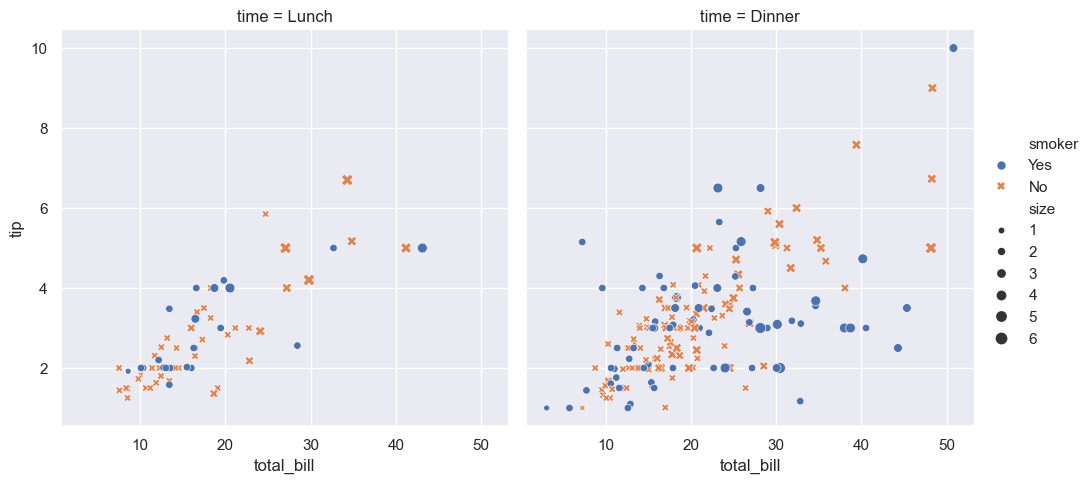

In [193]:
# Create a visualization
sns.relplot(
    data=dom_set,
    x="total", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

In [108]:
def create_upset_plot(df, categories, min_subset_size=2, figsize=(12, 8)):
    """ Create an upset plot showing category intersections with cutoff. """
    # Convert to the format needed by upsetplot
    df_upset = df[categories].copy()
    upset_data = from_indicators(df_upset)
    
    # Filter to only show intersections with at least min_subset_size incidents
    filtered_data = upset_data #[upset_data >= min_subset_size]
    
    print(f"Showing {len(filtered_data)} intersections with ≥{min_subset_size} incidents")
    print(f"Filtered out {len(upset_data) - len(filtered_data)} small intersections")
    plt.figure(figsize=figsize)  # Set figure size BEFORE creating UpSet plot
    # Create the plot
    upset_plot = UpSet(filtered_data, 
                       subset_size='count',
                       show_counts=True,
                       sort_by='cardinality',
                       sort_categories_by='cardinality')
    
    fig = upset_plot.plot()
    plt.suptitle(f'Category Intersections - Upset Plot (≥{min_subset_size} incidents)', 
                 fontsize=16, y=0.98)
    plt.tight_layout()

    return fig

In [113]:
print("\nCategory combinations per row:")
print(df[bins].sum(axis=1).value_counts().sort_index())


Category combinations per row:
0     81
1    196
2    193
3     94
4     23
5      2
Name: count, dtype: int64


In [114]:
def debug_upset_data(df, categories):
    """Debug function to see what intersections exist in your data"""
    from upsetplot import from_indicators
    
    print(f"DataFrame shape: {df.shape}")
    print(f"Categories: {categories}")
    print()
    
    # Check individual category counts
    print("Individual category counts:")
    for cat in categories:
        count = df[cat].sum()
        print(f"  {cat}: {count}")
    print()
    
    # Convert to upset format and check
    df_upset = df[categories].copy()
    upset_data = from_indicators(df_upset)
    
    print(f"Total intersections found: {len(upset_data)}")
    print(f"Intersection sizes:")
    
    # Show all intersections sorted by size
    sorted_intersections = upset_data.sort_values(ascending=False)
    
    for i, (intersection, count) in enumerate(sorted_intersections.items()):
        if i < 20:  # Show top 20
            intersection_names = [cat for cat, included in zip(categories, intersection) if included]
            if not intersection_names:
                intersection_names = ['No categories']
            print(f"  {' + '.join(intersection_names)}: {count}")
        elif i == 20:
            print(f"  ... and {len(sorted_intersections) - 20} more")
            break
    
    return upset_data

In [115]:
upset_data = debug_upset_data(df, bins)

DataFrame shape: (589, 33)
Categories: ['homey', 'bar_club', 'school', 'retail', 'outdoors', 'vehicle', 'gang', 'fight', 'domestic', 'suicide', 'youth']

Individual category counts:
  homey: 146
  bar_club: 145
  school: 28
  retail: 31
  outdoors: 164
  vehicle: 102
  gang: 6
  fight: 87
  domestic: 60
  suicide: 33
  youth: 164

Total intersections found: 589
Intersection sizes:
  No categories: 1.0
  homey: 1.0
  outdoors: 1.0
  homey + domestic: 1.0
  youth: 1.0
  retail: 1.0
  homey + bar_club + youth: 1.0
  homey + bar_club + fight: 1.0
  vehicle: 1.0
  outdoors: 1.0
  bar_club + outdoors: 1.0
  homey: 1.0
  homey + youth: 1.0
  outdoors + youth: 1.0
  fight: 1.0
  retail + youth: 1.0
  bar_club: 1.0
  retail: 1.0
  No categories: 1.0
  outdoors: 1.0
  ... and 569 more


In [109]:
bins = ['homey', 'bar_club', 'school', 'retail', 'outdoors', 'vehicle', 'gang', 'fight', 'domestic', 'suicide', 'youth']

Showing 589 intersections with ≥2 incidents
Filtered out 0 small intersections


C:\Users\andyg\anaconda3\envs\nlp_me\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\andyg\anaconda3\envs\nlp_me\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

<Figure size 1200x800 with 0 Axes>

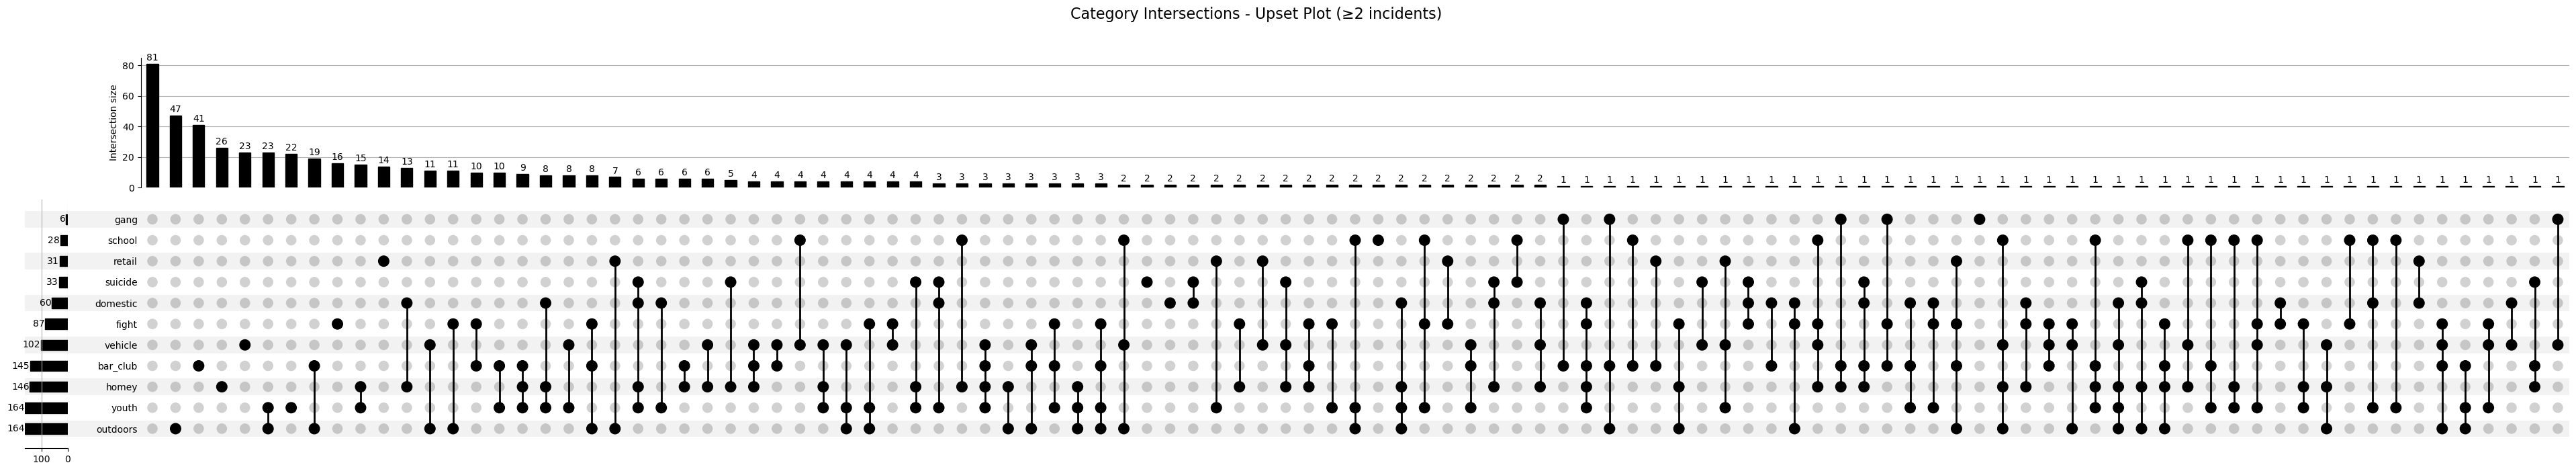

In [110]:
create_upset_plot(df, bins)

In [80]:
def create_overlap_matrix(df, categories, figsize=(12, 10)):
    """ Create an overlap matrix """
    
    # Calculate overlap matrix
    n_cats = len(categories)
    overlap_matrix = np.zeros((n_cats, n_cats))
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i == j:
                # Diagonal: individual category counts
                overlap_matrix[i, j] = df[cat1].sum()
            else:
                # Off-diagonal: intersection counts
                overlap_matrix[i, j] = (df[cat1] & df[cat2]).sum()
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Clean up category names for display
    clean_names = [cat.replace('_', ' ').title() for cat in categories]
    
    # Create heatmap
    sns.heatmap(overlap_matrix, 
                xticklabels=clean_names,
                yticklabels=clean_names,
                annot=True, 
                fmt='g',
                cmap='Blues',
                square=True,
                linewidths=0.5,
                cbar_kws={'label': 'Number of Incidents'},
                ax=ax)
    
    ax.set_title('Category Overlap Matrix\n(Diagonal = Individual Counts, Off-diagonal = Intersections)', 
                 fontsize=14, pad=20)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Categories') 
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return fig

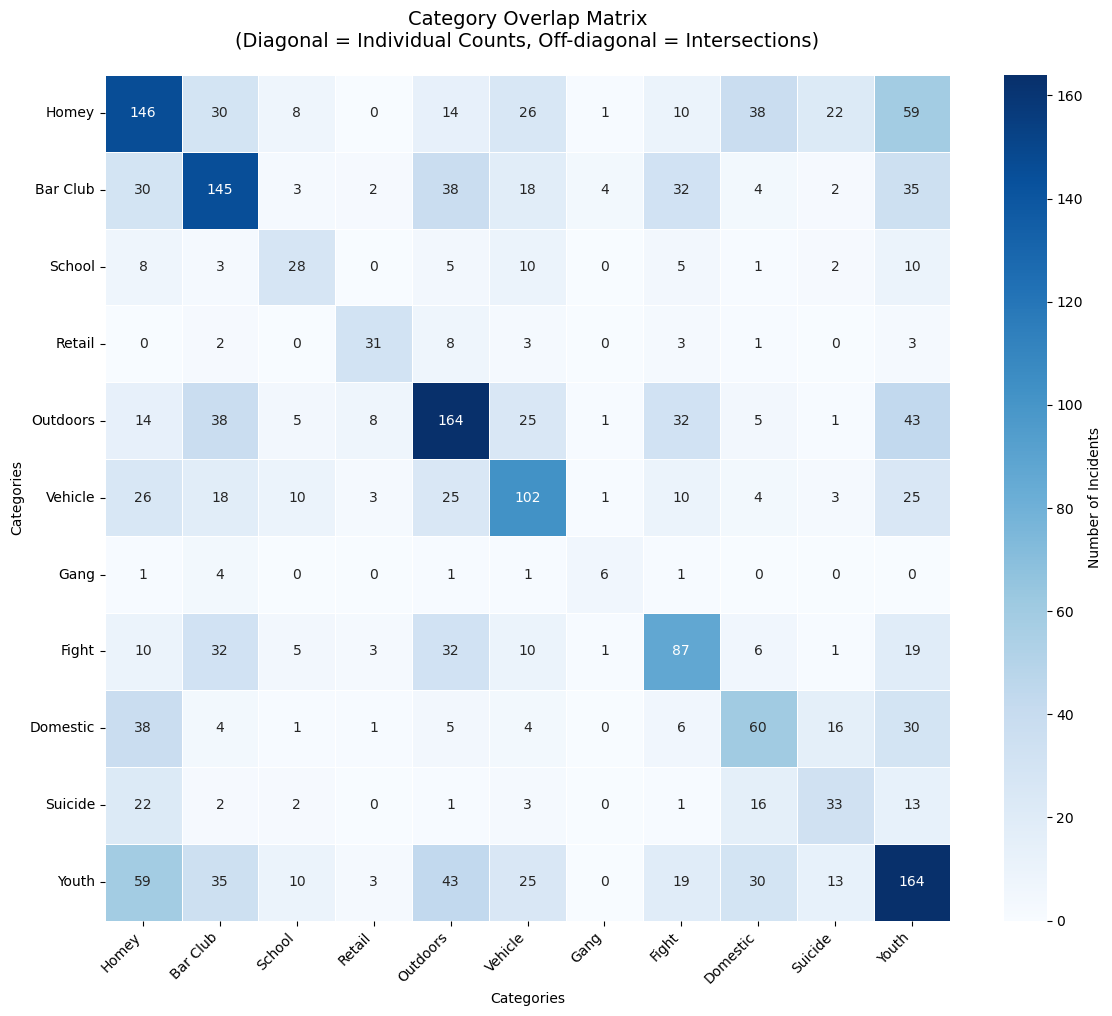

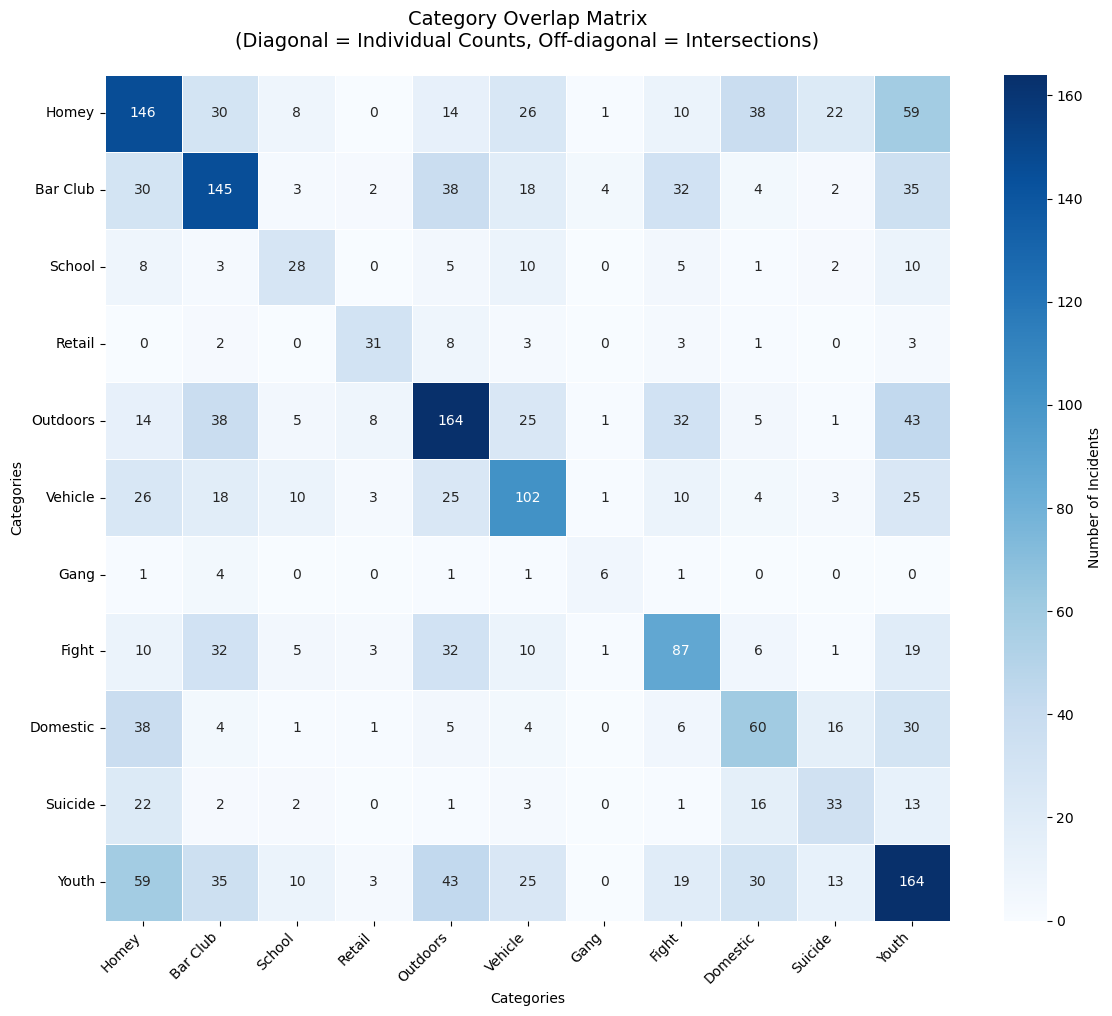

In [95]:
create_overlap_matrix(df, bins)